In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import glob
import math
from skimage.feature import corner_harris,corner_peaks
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
from tracker import tracker
%matplotlib inline

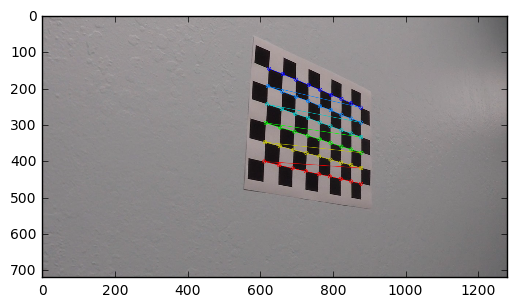

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found' + str(idx) + '.jpg'
        cv2.imwrite(write_name, img)

plt.imshow(img)
        
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./calibration_pickele.p", "wb"))


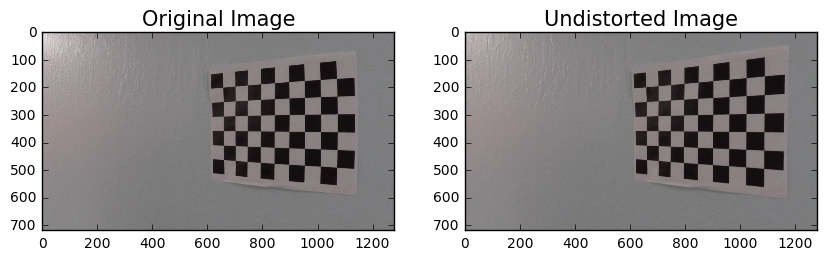

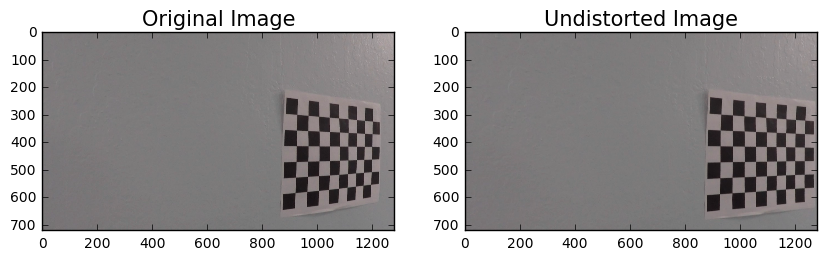

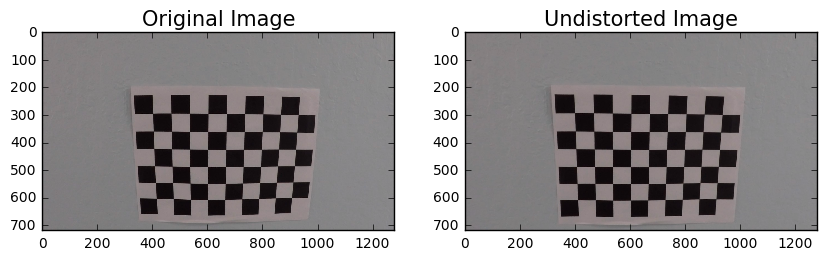

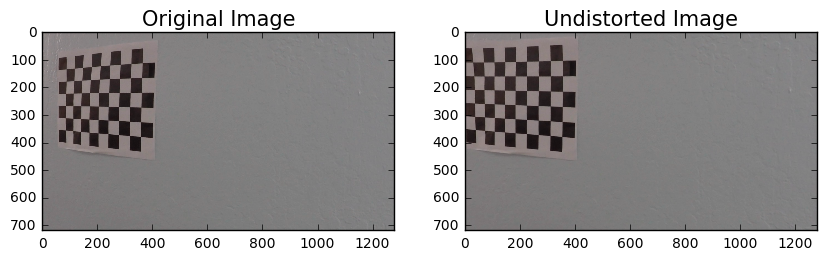

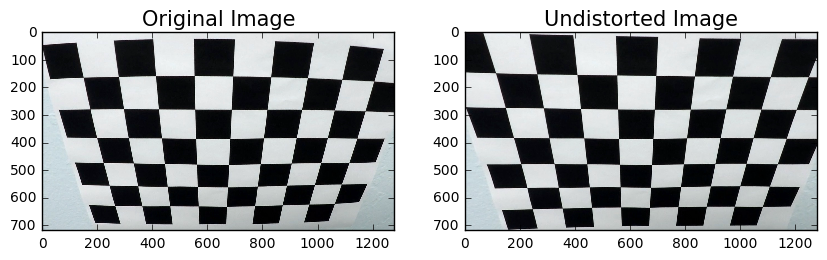

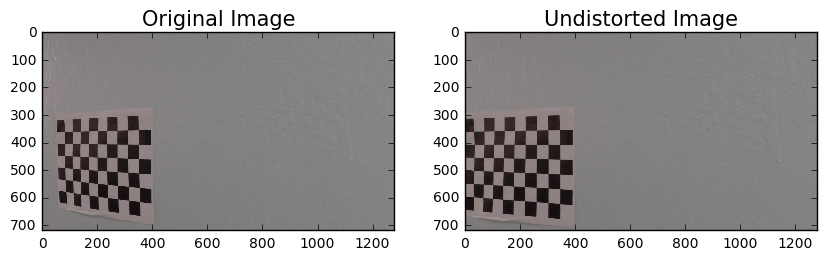

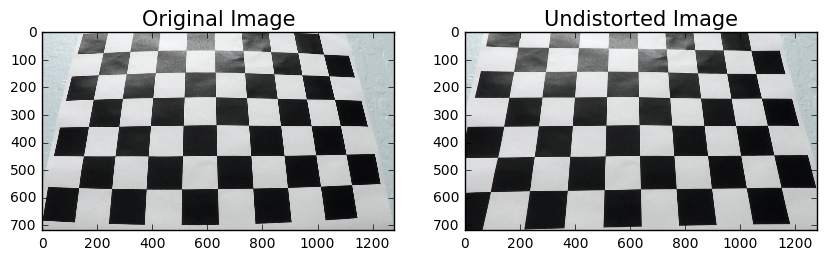

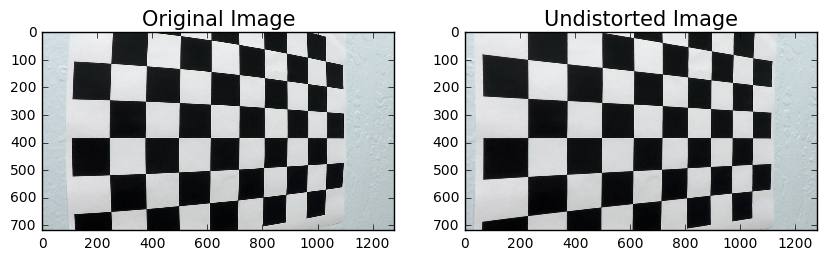

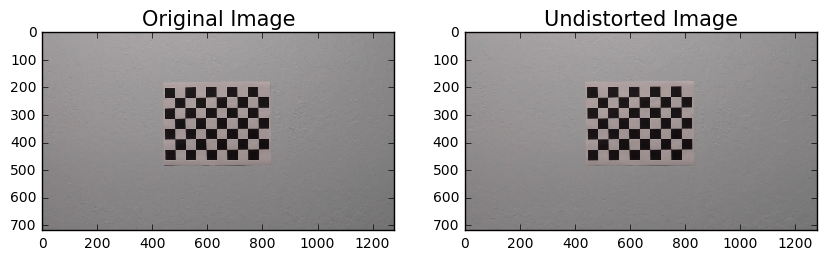

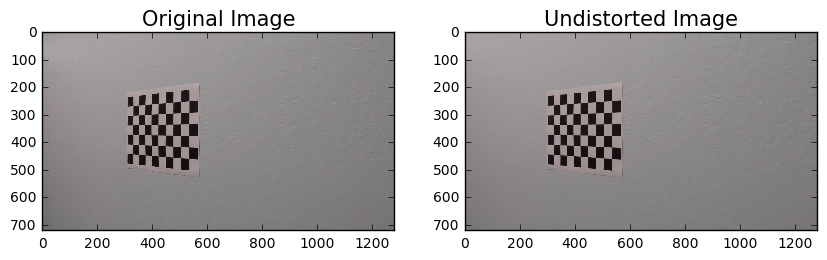

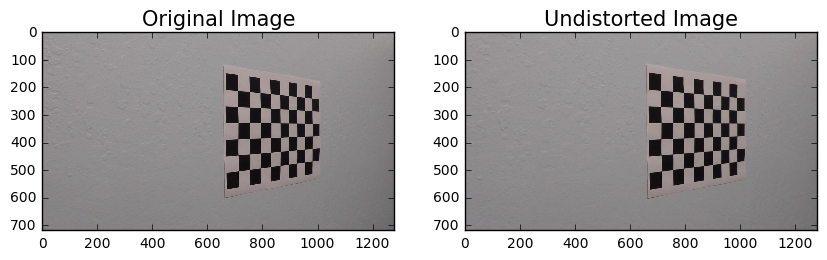

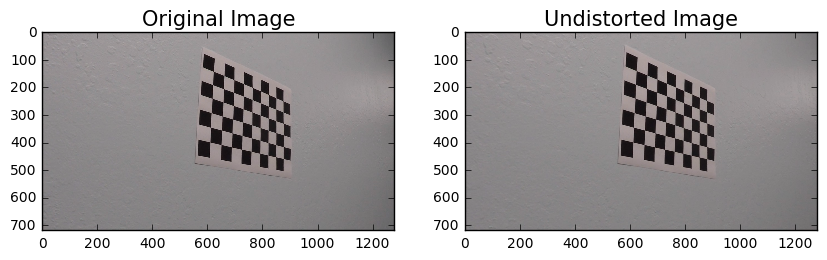

In [4]:
dist_pickle = pickle.load(open("calibration_pickele.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)    
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'undistorted' + str(idx) + '.jpg'
    cv2.imwrite(write_name, undst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize = 15)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize = 15)


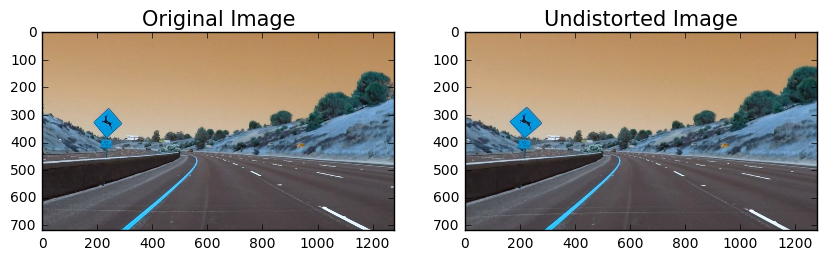

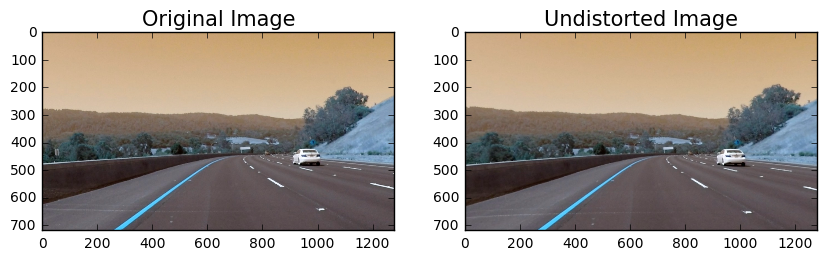

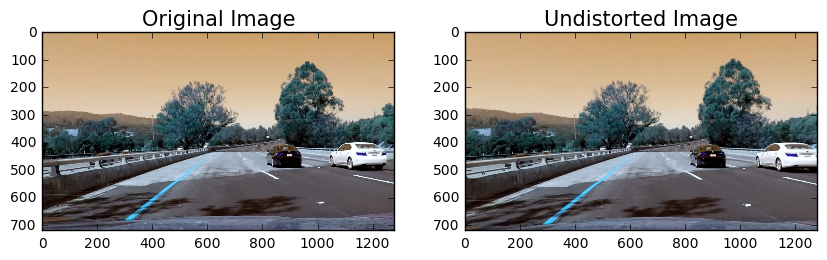

In [5]:
images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)    
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'undistorted_test' + str(idx) + '.jpg'
    cv2.imwrite(write_name, undst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize = 15)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize = 15)


In [6]:
dist_pickle = pickle.load(open("calibration_pickele.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
ksize = 5

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gauss_img = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    return gauss_img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def abs_sobel_thresh(img, orient = 'x', sobel_kernel=ksize, thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel >= thresh[1])] = 1
    return grad_binary


def mag_thresh(img, sobel_kernel=ksize, thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(mag)/255
    scaled_mag = np.uint8(mag/scale_factor)
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=ksize, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return dir_binary

def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255), hthresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > hthresh[0]) & (h_channel <= hthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1 #& (h_binary)] = 1
    return output

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def visualise(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [9]:
images = glob.glob('./test_images/test*.jpg')
kernel_size = 15
processed_image = []
threshold_image = []
warped_images = []
roads = []
lane_fit = []
pixel_images = []
titles = []
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    imshape = undist.shape
    vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
    gauss_img = gaussian_blur(undist, kernel_size)
    preprocess_image = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(gauss_img, orient='x', thresh=(50, 255))
    gradx = region_of_interest(gradx, vertices)
    grady = abs_sobel_thresh(gauss_img, orient='y', thresh=(30, 255))
    grady = region_of_interest(grady, vertices)
    c_binary = color_threshold(img, sthresh=(100, 255), vthresh=(60, 255))
    c_binary = region_of_interest(c_binary, vertices)
    mag_binary = mag_thresh(gauss_img, sobel_kernel=9, thresh=(50, 200))
    mag_binary = region_of_interest(mag_binary, vertices)
    preprocess_image[((gradx == 1) & (grady == 1) | (c_binary == 1) | (mag_binary == 1))] = 255
    img_size = (img.shape[1], img.shape[0])
    threshold_image.append(preprocess_image)
#     bot_width = 0.75
#     mid_width = 0.08
#     height_pct = 0.62
#     bot_trim = 0.935

#     src = np.float32([[595,  460], [710,  460], [973,  677], [307,  677]])
#     dst = np.float32([[320, 0], [960, 0], [960, 720], [320, 720]])

    src = np.float32(
        [[585. /1280.*img_size[0], 455./720.*img_size[1]],
        [705. /1280.*img_size[0], 455./720.*img_size[1]],
        [1120./1280.*img_size[0], 720./720.*img_size[1]],
        [190. /1280.*img_size[0], 720./720.*img_size[1]]])

    dst = np.float32(
        [[300. /1280.*img_size[0], 100./720.*img_size[1]],
        [1000./1280.*img_size[0], 100./720.*img_size[1]],
        [1000./1280.*img_size[0], 720./720.*img_size[1]],
        [300. /1280.*img_size[0], 720./720.*img_size[1]]])

#     src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
#                             [705. /1280.*img_size[1], 455./720.*img_size[0]],
#                             [1130./1280.*img_size[1], 720./720.*img_size[0]],
#                             [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
#     dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
#                             [1000./1280.*img_size[1], 100./720.*img_size[0]],
#                             [1000./1280.*img_size[1], 720./720.*img_size[0]],
#                             [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    
    
#     src = np.float32(
#         [[(img_size[0] * 3/16) - 20, img_size[1]],
#          [(img_size[0] - 60), img_size[1]],
#          [(img_size[0]/2 + 110), img_size[1] * 2/3],
#          [(img_size[0]/3 + 125), img_size[1] * 2/3]])

#     dst = np.float32(
#         [[(img_size[0] * 3/16), img_size[1]],
#          [(img_size[0] * 13/16), img_size[1]],
#          [(img_size[0] * 13/16), img_size[1]/2 - 60],
#          [(img_size[0] * 3/16), img_size[1]/2 - 60]])

#     src=np.float32([[(160,img_size[1]),(img_size[0]/2-60, img_size[1]/2+90),
#                   (img_size[0]/2+100, img_size[1]/2+90), (img_size[0]-20,img_size[1])]], dtype=np.int32)
#     dst=np.float32([[(240,img_size[1]),(240, 0),(img_size[0]-130, 0), (img_size[0]-130,img_size[1])]])


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(preprocess_image, M, img_size, flags=cv2.INTER_LINEAR)
    
    warped_images.append(warped)
    
    window_width = 25
    window_height = 65
    
    #setting up the tracker
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height= window_height, Mymargin= 25, My_ym = 10/720, My_xm = 4/384, Mysm_factor = 15)
    window_centroids = curve_centers.find_window_centroids(warped)
    
     # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    #points used to find the left and right lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        
        #add center value found in frame to the list of the lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
        
    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result_1 = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
    lane_fit.append(result_1)

#     #fit the lane boundaries to the left, right and center position found
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis = 0), 
                                  np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1] + window_width/2), axis = 0), 
                                  np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1] + window_width/2), axis = 0), 
                                  np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    
    road = np.zeros_like(img)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    cv2.fillPoly(road, [left_lane], color=[255, 0, 0])
    cv2.fillPoly(road, [right_lane], color=[0, 0, 255])
    
    pixel_images.append(road)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(road, np.int_([pts]), (0,255, 0))
    roads.append(road)
    
    unwarp_lane2 = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarp_lane2, 0.3, 0)
#    road_warped = cv2.warpPerspective(result, Minv, img_size, flags=cv2.INTER_LINEAR)
#     result = cv2.addWeighted(img, 1.0, road_warped, 2.0, 0.0)

    ym_per_pix = curve_centers.ym_per_pix
    xm_per_pix = curve_centers.xm_per_pix
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if left_curverad > right_curverad:
        curverad = left_curverad - right_curverad
    else:
        curverad = right_curverad - left_curverad
    left_text = "Left curvature " + str(left_curverad)
    right_text = "Right curvature " + str(right_curverad)
    font = cv2.FONT_HERSHEY_COMPLEX
    
    #curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
    #curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.absolute(2*curve_fit_cr[0])
    
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'
        
    radius_curve = "Radius of curvature " + str(round(curverad)) + 'm'
    cv2.putText(result, radius_curve, (30, 45), font, 1, (0, 0, 255), 2)
    cv2.putText(result, 'Vehicle is ' + str(abs(round(center_diff, 3))) +'m ' + side_pos + ' of center', (30, 90), font, 1, (0, 0, 255), 2)
    
    processed_image.append(result)
    titles.append('')


fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5, 2, processed_image, titles)
# output_video = 'Output_processed.mp4'
# input_video = 'project_video.mp4'

# clip1 = VideoFileClip(input_video)

    
#     write_name = './test_images/processed' + str(idx) + '.jpg'
#     cv2.imwrite(write_name, result)
    

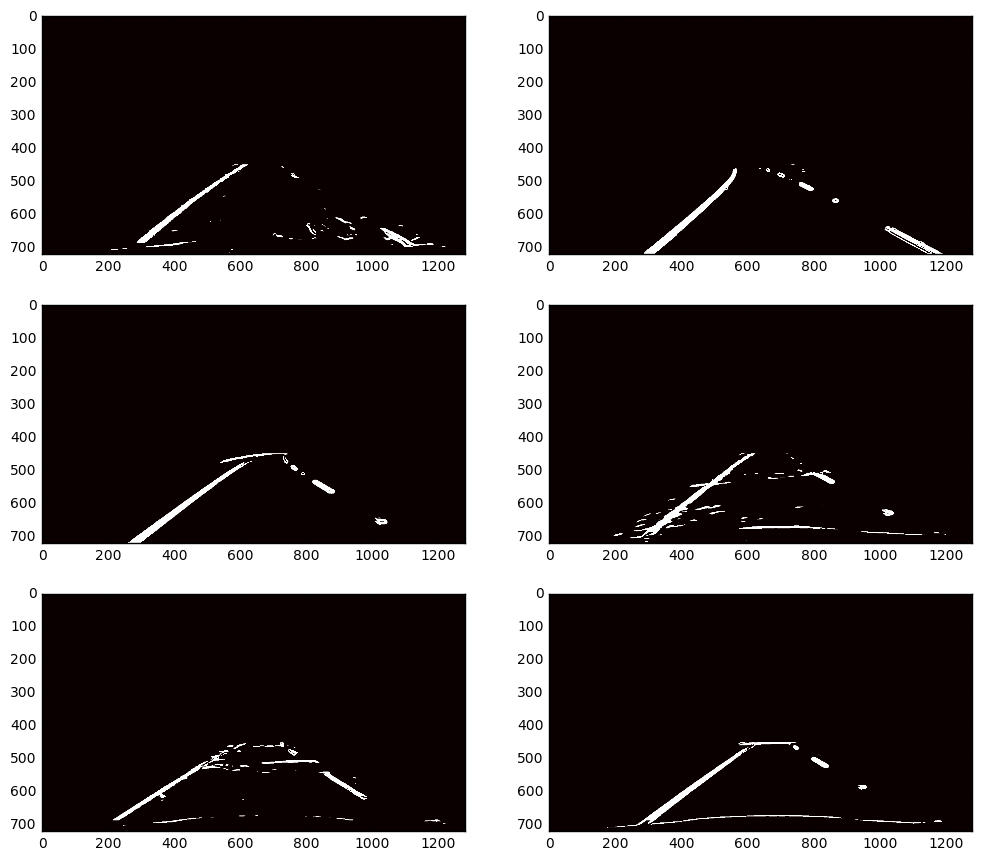

In [7]:
fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5, 2, threshold_image, titles)

In [8]:
for idx, fname in enumerate(threshold_image):    
    write_name = 'threshold_image_test' + str(idx) + '.jpg'
    cv2.imwrite(write_name, fname)

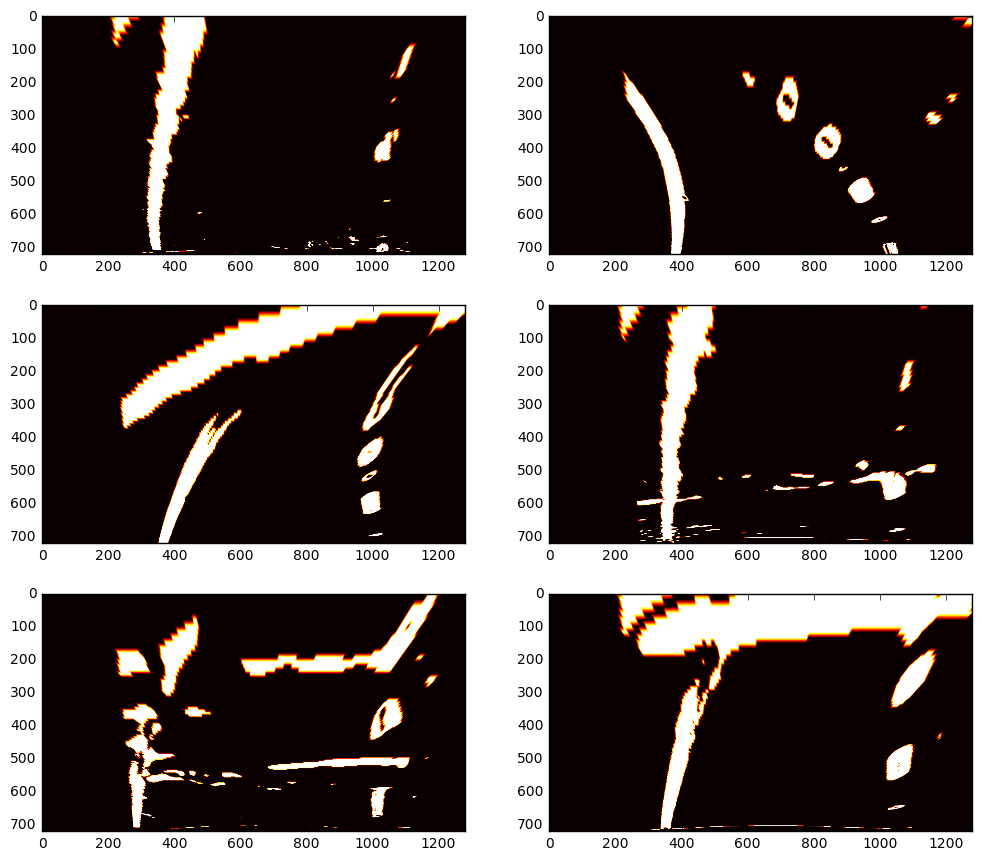

In [9]:
fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5, 2, warped_images, titles)

In [10]:
for idx, fname in enumerate(warped_images):    
    write_name = 'warped_image_test' + str(idx) + '.jpg'
    cv2.imwrite(write_name, fname)

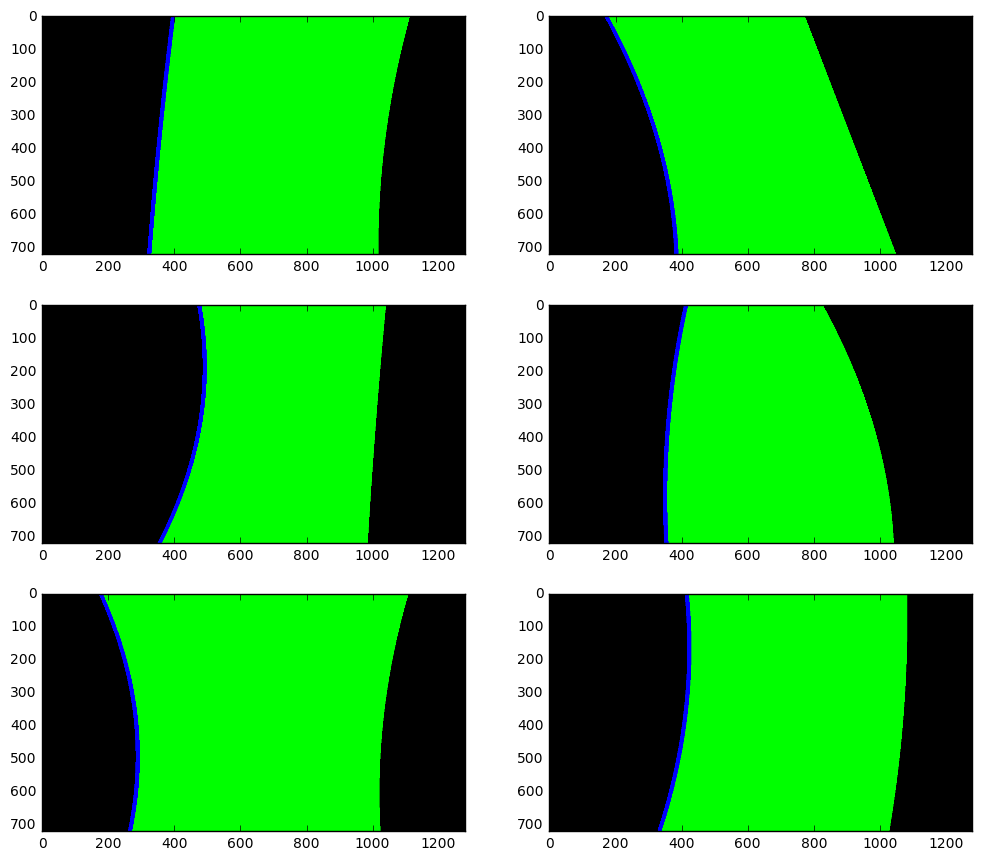

In [11]:
fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5, 2, pixel_images, titles)

In [ ]:
fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5, 2, roads, titles)

In [ ]:
for idx, fname in enumerate(roads):    
    write_name = 'output_images/road_image_test' + str(idx) + '.jpg'
    cv2.imwrite(write_name, fname)

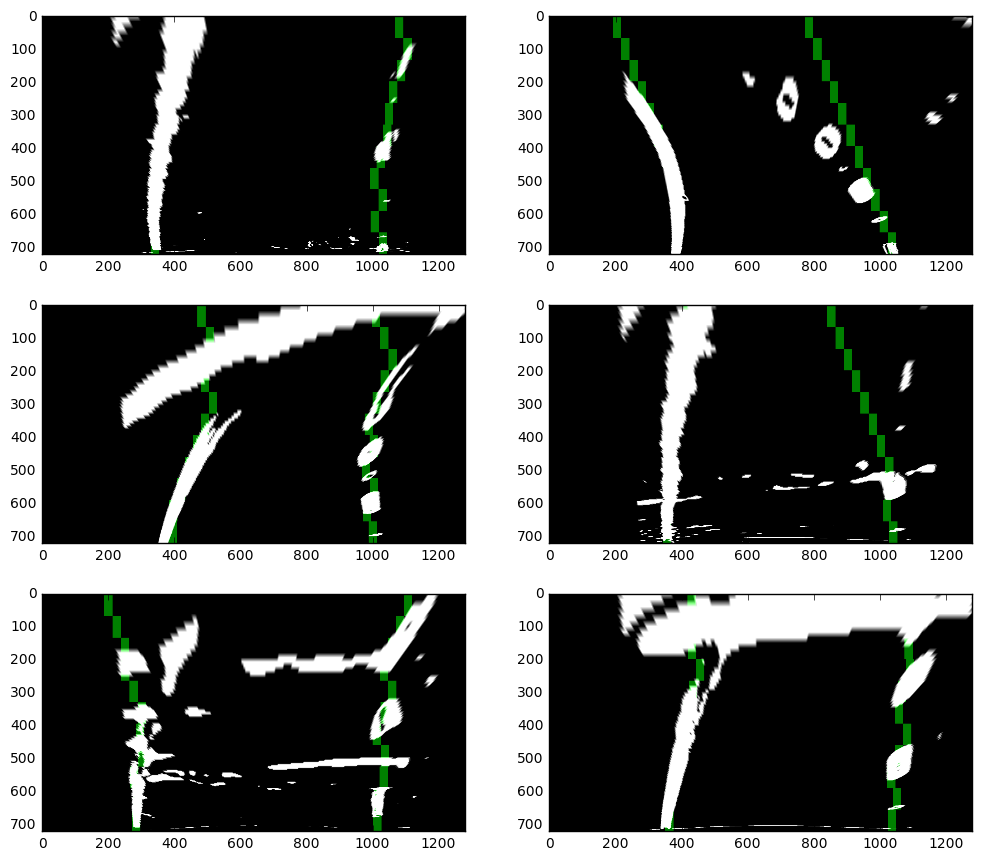

In [10]:
fig = plt.figure(figsize=(12,18), dpi=300)
visualise(fig, 5, 2, lane_fit, titles)

In [11]:
for idx, fname in enumerate(lane_fit):    
    write_name = 'output_images/lane_image_test' + str(idx) + '.jpg'
    cv2.imwrite(write_name, fname)

In [12]:
for idx, fname in enumerate(processed_image):    
    write_name = 'output_images/final_image_test' + str(idx) + '.jpg'
    cv2.imwrite(write_name, fname)